![](images/notebook-images/linreg-house-prices/houses_breno-assis_unsplash.jpg){fig-align="center"}

<center><a href = "https://unsplash.com/photos/r3WAWU5Fi5Q">Unsplash | Breno Assis</a></center>

# Introduction

The Ames, Iowa housing dataset was formed by De Cock in 2011 as a high-quality dataset for regression projects. It contains data on 80 features of 2930 houses. The target variable is the sale price of each house.

In order to predict the target, I will use linear regression for both statistical inference and machine learning. To each feature (or independent variable), the model will assign a coefficient that shows how the feature affects the target (or dependent variable). I will use the model's $p$ values to determine the features with statistically significant effects, then use these features in our final model for predicting prices from new data.

:::{.callout-note}

I wrote this notebook by following a guided project on the [Dataquest](https://www.dataquest.io/) platform, specifically the [Guided Project: Predicting House Sale Prices](https://app.dataquest.io/c/41/m/240/guided-project%3A-predicting-house-sale-prices/1/introduction). The general project flow and research questions were guided by Dataquest. Other than what was instructed, I also added my own steps. You can visit the [official solution](https://github.com/dataquestio/solutions/blob/master/Mission240Solutions.ipynb) to compare it to my project.

:::

Below are the packages used in this project.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sms
from sklearn.linear_model import LinearRegression

# Import custom modules that I wrote.
from custom_modules import linreg_tools as lrt, stratified_kfcv as skf

Note that some of the imported modules are custom ones that I wrote. To view these modules, visit this [directory](https://github.com/MiguelAHG/mahg-data-science/tree/master/_notebooks/custom_modules) in my website's repository.

# Data Inspection and Cleaning

The journal article that introduced the Ames, Iowa housing dataset is linked [here](https://www.tandfonline.com/doi/abs/10.1080/10691898.2011.11889627). You may click the "PDF" button on the webpage to access the article, which contains the links to download the data file.

A summary of the columns and their data types is shown below.

In [2]:
#| code-fold: true
houses = pd.read_excel("./private/Linear-Regression-House-Prices-Files/AmesHousing.xls")

houses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2930 non-null   int64  
 1   PID              2930 non-null   int64  
 2   MS SubClass      2930 non-null   int64  
 3   MS Zoning        2930 non-null   object 
 4   Lot Frontage     2440 non-null   float64
 5   Lot Area         2930 non-null   int64  
 6   Street           2930 non-null   object 
 7   Alley            198 non-null    object 
 8   Lot Shape        2930 non-null   object 
 9   Land Contour     2930 non-null   object 
 10  Utilities        2930 non-null   object 
 11  Lot Config       2930 non-null   object 
 12  Land Slope       2930 non-null   object 
 13  Neighborhood     2930 non-null   object 
 14  Condition 1      2930 non-null   object 
 15  Condition 2      2930 non-null   object 
 16  Bldg Type        2930 non-null   object 
 17  House Style   

The output above shows the name of each column, its number of non-null values, and its data type. Most of the names are self-explanatory, but others are not so clear. One can visit the [data documentation](https://s3.amazonaws.com/dq-content/307/data_description.txt) to learn what each column represents.

Here are the first steps I took in order to clean these columns:

- Based on a suggestion in page 4 of De Cock (2011), I deleted 5 outlier observations which had above-ground living areas higher than 4000 square feet.
- I selected 9 useful numeric/ordinal columns and 2 useful categorical columns based on their descriptions in the data documentation.
- I transformed the `Overall Qual` and `Overall Cond` columns. Originally, these contained integers from 1 to 10, which represented ordinal ratings from Very Poor to Very Excellent. I put these ratings into 4 groups:
    - 1 represents Very Poor to Fair
    - 2 represents Below Average to Above Average
    - 3 represents Good and Very Good
    - 4 represents Excellent and Very Excellent
- I inspected the missing values in my final set of columns.

In [3]:
#| code-fold: true
# Remove outliers based on suggestion in journal article
houses = houses.loc[houses["Gr Liv Area"] < 4000]

# Identify important columns
useful_numerics = [
    "Lot Frontage",
    "Lot Area",
    "Mas Vnr Area",
    "Total Bsmt SF",
    "Gr Liv Area",
    "Fireplaces",
    "Garage Area",
    # The 2 below are ordinal.
    "Overall Qual",
    "Overall Cond",
]

useful_categoricals = [
    "Lot Config",
    "Bldg Type",
]

target_col = "SalePrice"

# Keep only the important columns
houses = houses.loc[:, useful_numerics + useful_categoricals + [target_col]]

ratings_simplified = {
    10: 4,
    9: 4,
    8: 3,
    7: 3,
    6: 2,
    5: 2,
    4: 2,
    3: 1,
    2: 1,
    1: 1,
}

# Replace integers in these two columns with a new set of integers
for col in ["Overall Qual", "Overall Cond"]:
    houses[col] = houses[col].replace(ratings_simplified)

houses.isnull().sum() / houses.shape[0] * 100

Lot Frontage     16.752137
Lot Area          0.000000
Mas Vnr Area      0.786325
Total Bsmt SF     0.034188
Gr Liv Area       0.000000
Fireplaces        0.000000
Garage Area       0.034188
Overall Qual      0.000000
Overall Cond      0.000000
Lot Config        0.000000
Bldg Type         0.000000
SalePrice         0.000000
dtype: float64

The table above shows the percentage of missing values in each column. Most columns have less than 1% missingness, but the `Lot Frontage` column has almost 17% missingness. This is higher than my preferred benchmark of 5% missingness, so I will remove the `Lot Frontage` column.

After deleting that column, I will remove rows where there are any remaining missing values.

In [4]:
#| code-fold: true
houses = houses.drop("Lot Frontage", axis = 1).dropna()

print(f"Total number of missing values: {houses.isnull().sum().sum()}")
print(f"New shape: {houses.shape}")

Total number of missing values: 0
New shape: (2900, 11)


Now, the dataset has 2900 rows and 11 columns, including 10 features and 1 target.

Next, two of my features are categorical. Thus, in order to use them in regression, I have to dummy code them. According to the UCLA: Statistical Consulting Group (2021), if there are $k$ categories in one variable, I must make $k - 1$ new variables containing zeroes and ones. The reason that only $k - 1$ variables are made is that one category has to be set aside as the "reference level." The other categories will be compared to the reference level when I fit the model.

In Python, I will do this using the `pd.get_dummies()` function. I will set the `drop_first` parameter to `True` so that one category will be excluded from the final variables.

In [5]:
#| code-fold: true
cat_features = ["Lot Config", "Bldg Type"]

houses = houses.merge(
    pd.get_dummies(houses[cat_features], drop_first = True),
    left_index = True,
    right_index = True,
    how = "outer",
)

houses = houses.drop(cat_features, axis = 1)

(
    houses
    .loc[:, houses.columns.to_series().str.match(r"Lot Config|Bldg Type")]
    .head()
)

,Lot Config_CulDSac,Lot Config_FR2,Lot Config_FR3,Lot Config_Inside,Bldg Type_2fmCon,Bldg Type_Duplex,Bldg Type_Twnhs,Bldg Type_TwnhsE
0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0


The table above shows the first 5 rows of the new variables that were created. Since there were 5 categories in the `Lot Config` variable, 4 new variables were created. This is also the case for the `Bldg Type` variable.

Let's take the first column, `Lot Config_CulDSac`, as an example. It represents houses that are situated on a cul-de-sac. A house with a value of 1 in this column is a house on a cul-de-sac. Other houses, with values of 0, are not.

The data is clean now, so I can proceed to statistical inference.

# Statistical Inference

In this section, I will fit an Ordinary least Squares (OLS) linear regression model. Then, I will check the assumptions of linear regression in order to make sure that this is the right model for the problem. I will also use the results of the model to select the best features.

The code below fits the OLS model and outputs the first of three tables of results. I will interpret the results based on what I learned from the article "Linear Regression" by Python for Data Science (n.d.).

In [6]:
#| code-fold: true
feature_cols = [x for x in houses.columns if x != target_col]

# Add a constant column in the dataset so that the model can find the y-intercept.
X = sms.add_constant(
    houses[feature_cols]
)
y = houses[target_col]

# Obtain Variance Inflation Factors.
vif_df = lrt.get_vif(X)

model = sms.OLS(y, X)
results = model.fit()
summary = results.summary()

tables = lrt.extract_summary(summary, vif_df)

tables[0]

C:\Users\migs\anaconda3\envs\new_streamlit_env2\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,0,1,2,3
0,Dep. Variable:,SalePrice,R-squared:,0.838
1,Model:,OLS,Adj. R-squared:,0.837
2,Method:,Least Squares,F-statistic:,929.200
3,Date:,"Fri, 14 Jan 2022",Prob (F-statistic):,0.000
4,Time:,14:44:14,Log-Likelihood:,-34163.000
5,No. Observations:,2900,AIC:,68360.000
6,Df Residuals:,2883,BIC:,68460.000
7,Df Model:,16,NaN,NaN
8,Covariance Type:,nonrobust,NaN,NaN


This first table shows two important things. The R-squared value is equal to 0.838, meaning that the model explained 83.8% of the variance in the data. Ideally, I would want a value close to 100% but this is good. Also, the p value of the F-statistic is equal to 0. Since $p < 0.05$, the model was statistically significant overall.

Next, below is the second table of results.

In [7]:
#| code-fold: true
tables[1]

,coef,std err,t,P>|t|,[0.025,0.975],VIF
feature,,,,,,,
const,-105800.0000,4319.486,-24.498,0.000,-114000.000,-97400.000,53.813031
Lot Area,0.5717,0.084,6.789,0.000,0.407,0.737,1.243636
Mas Vnr Area,49.6396,3.863,12.849,0.000,42.065,57.214,1.334007
Total Bsmt SF,40.8966,1.780,22.979,0.000,37.407,44.386,1.618427
Gr Liv Area,48.9365,1.660,29.481,0.000,45.682,52.191,1.883476
Fireplaces,7000.7868,1069.148,6.548,0.000,4904.416,9097.158,1.373267
Garage Area,53.8240,3.528,15.256,0.000,46.906,60.742,1.643206
Overall Qual,44530.0000,1344.831,33.113,0.000,41900.000,47200.000,1.924753
Overall Cond,9206.0505,1269.656,7.251,0.000,6716.526,11700.000,1.056642


Each row other than the `constant` row represents a feature.

The `coef` column gives the increase in the target for a one-unit increase in the feature (Frost, 2017). For example, the coefficient of `Gr Liv Area` (above-ground living area in square feet) is around 49. Therefore, for every 1 square foot increase in living area, the sale price increases by USD 49.

According to UCLA: Statistical Consulting Group (2021), the coefficient of a dummy-coded variable gives the difference between the mean of the target for the level of interest and the mean of the target for the reference level. For example, the coefficient of `Lot Config_CulDSac` is 14,770. Therefore, the price of a house on a cul-de-sac is usually USD 14,770 higher than that of a house on a corner lot.

The `P>|t|` column gives the p value of each feature. A p value less than 0.05 can be considered statistically significant, whereas a p value above that threshold is not. In the case of this model, most of the features are statistically significant.

The insignificant features are `Lot Config_FR2` (houses with frontage on 2 sides), `Lot Config_FR3`, and `Bldg Type_TwnhsE` (Townhouse End Units). Though these are not significant, I will keep them in the model because they are necessary components of the dummy-coded categorical variables.

Next, the `VIF` column contains Variance Inflation Factors. I wrote code to calculate these values based on an article, "Detecting Multicollinearity with VIF – Python," by cosine1509 (2020).

According to Frost (2017), VIFs are a measure of **multicollinearity** among independent variables. The lowest possible value is 1, which means no collinearity at all. Values between 1 and 5 show low to moderate multicollinearity, so these are acceptable. However, values over 5 show high multicollinearity and need to be investigated.

In the case of this model, all of the VIFs of the features are below 2. The VIF of the constant term is high, but this is not important.

In summary, based on the p values and VIF values, there is no need to change the features used in the model. Most of them are significant, and all of them have low multicollinearity.

Finally, let us look at the third table of results.

In [8]:
#| code-fold: true
tables[2]

,0,1,2,3
0,Omnibus:,421.519,Durbin-Watson:,1.583
1,Prob(Omnibus):,0.000,Jarque-Bera (JB):,3490.274
2,Skew:,0.426,Prob(JB):,0.000
3,Kurtosis:,8.307,Cond. No.,195000.000


The Durbin-Watson test statistic is 1.583. According to Python for Data Science (n.d.), this statistic should ideally be close to 2. If it is below 2, there is positive autocorrelation among the residuals, so one of the assumptions of linear regression is violated. However, as a rule of thumb, values between 1.5 and 2.5 are acceptable. Thus, this statistic is not a cause of concern.

On the other hand, the Jarque-Bera p value is 0. Because $p < 0.05$, the statistic is significant, so the residuals are not distributed normally. However, Mordkoff (2016) says that according to the Central Limit Theorem, "as long as the sample is based on 30 or more observations, the sampling distribution of the mean can be safely assumed to be normal." Therefore, this is fine.

That's it for the statistical inference part of this project. Now that I know that my variables are statistically significant, I can make a predictive model and evaluate it.

# Predictive Modeling and Evaluation

In this last part, I will use scikit-learn to fit a linear regression model for prediction. A 5-fold cross-validation will be used in order to evaluate the model.

In my [recent project](2021-12-21-Predicting-Car-Prices-K-Nearest-Neighbors.ipynb) about the KNN model, I wrote some custom functions that help perform *stratified* cross-validation. This means that the folds are divided such that each fold's target distribution (in this case, price distribution) is similar to that of the full sample. I put the custom functions in this [module](https://github.com/MiguelAHG/mahg-data-science/blob/master/_notebooks/custom_modules/stratified_kfcv.py) for your reference.

I performed stratified 5-fold cross-validation on the housing data, so 5 models were fitted and their RMSEs were recorded. The results are shown below.

In [9]:
#| code-fold: true
fold_series = skf.stratify_continuous(
    n_folds = 5,
    y = houses["SalePrice"],
)

lr = LinearRegression()

mse_lst = skf.stratified_kfcv(
    X = sms.add_constant(houses[feature_cols]),
    y = houses[target_col],
    fold_series = fold_series,
    regression_model = lr,
)

rmses = pd.Series(mse_lst).pow(1/2)

print(f"""RMSE Values:
{rmses}
Mean RMSE: {rmses.mean()}
SD RMSE: {rmses.std(ddof = 1)}""")

RMSE Values:
0    32046.873780
1    30927.932397
2    30637.750905
3    33020.953872
4    32832.216461
dtype: float64
Mean RMSE: 31893.145482987817
SD RMSE: 1082.253470974206


C:\Users\migs\anaconda3\envs\new_streamlit_env2\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


The mean RMSE is 31,893. Therefore, the predicted prices are usually USD 31,893 away from the true prices. Also, the standard deviation RMSE is around 1082, so the RMSE values were relatively consistent from test to test.

The mean RMSE may seem high, but remember the distribution of house prices in the dataset:

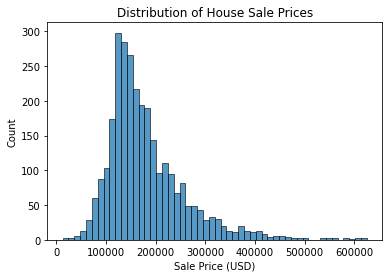

In [12]:
#| code-fold: true
sns.histplot(
    data = houses,
    x = "SalePrice"
)

plt.title("Distribution of House Sale Prices")
plt.xlabel("Sale Price (USD)")
plt.show()

The prices are mostly around USD 100,000 to USD 300,000. Thus, the mean RMSE is relatively small considering the prices. Therefore, I would say that the model performs decently, but it could be improved.

# Conclusion

In this project, I cleaned data about houses in Ames, Iowa, selected features that may be useful, interpreted linear regression results to determine significant features, then evaluated a predictive model. I found that the 16 independent variables explained 83.8% of the variance $(R^2 = 0.838, F(16, 2883 = 929.2), p < 0.05)$. Furthermore, the predictive model had a mean RMSE of 31,880, which was decent but not ideal.

Thanks for reading!

# Bibliography

## Data Source

De Cock, D. (2011). Ames, Iowa: Alternative to the Boston Housing Data as an End of Semester Regression Project. Journal of Statistics Education, 19(3), null. https://doi.org/10.1080/10691898.2011.11889627

## Information Sources

Coding Systems for Categorical Variables in Regression Analysis. (n.d.). UCLA: Statistical Consulting Group. Retrieved December 26, 2020, from https://stats.idre.ucla.edu/spss/faq/coding-systems-for-categorical-variables-in-regression-analysis-2/

cosine1509. (2020, August 14). Detecting Multicollinearity with VIF - Python. GeeksforGeeks. https://www.geeksforgeeks.org/detecting-multicollinearity-with-vif-python/

Frost, J. (2017a, April 2). Multicollinearity in Regression Analysis: Problems, Detection, and Solutions. Statistics By Jim. http://statisticsbyjim.com/regression/multicollinearity-in-regression-analysis/

Frost, J. (2017b, April 12). How to Interpret P-values and Coefficients in Regression Analysis. Statistics By Jim. http://statisticsbyjim.com/regression/interpret-coefficients-p-values-regression/

Mordkoff, J. T. (2016). The Assumption(s) of Normality. http://www2.psychology.uiowa.edu/faculty/mordkoff/GradStats/part%201/I.07%20normal.pdf

Python for Data Science. (2018, March 15). Linear Regression. Python for Data Science. https://pythonfordatascienceorg.wordpress.com/linear-regression-python/

## Image Source

Assis, B. (2018, January 17). Photo by Breno Assis on Unsplash. Unsplash. https://unsplash.com/photos/r3WAWU5Fi5Q